In [118]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras import backend as K
import os
import numpy as np
import uuid
import re
import matplotlib.pyplot as plt

In [2]:
from trainlib.ModelCollection import ModelCollection
from trainlib.ModelCollectionConfigFileHandler import ModelCollectionConfigFileHandler
from trainlib.FileCollection import FileCollection
from trainlib.config import Config
from trainlib.utils import read_data
from trainlib.PlottingUtils import extract_column, extract_columns
import trainlib.cuts as cuts

Welcome to JupyROOT 6.10/09


In [38]:
def generate_empty_input(input_columns, fixed_input):
    generated_input = {}
    
    for column_name in input_columns:  
        if column_name in list_inputs:
            generated_input[column_name] = np.zeros(4)
        else:
            generated_input[column_name] = 0
    
    generated_input.update(fixed_input)
    
    return generated_input

In [28]:
def evaluate_model_batch(model, pre, queue_df):
    pre_data = pre.process(queue_df)
    
    output = model.get_keras_model().predict(x = pre_data, verbose = 0, batch_size = len(pre_data))
    return output

In [29]:
def add_to_queue(queue, input_list, input_columns, fixed_input):
    queue = queue.append(fill_inputs_from_list(input_columns, input_list, fixed_input), ignore_index = True)
    return queue

In [30]:
def evaluate_model(model, pre, input_dict):
    df = pd.DataFrame()
    df = df.append(input_dict, ignore_index = True)
    pre_data = pre.process(df)
        
    output = model.get_keras_model().predict(x = pre_data, verbose = 0, batch_size = len(pre_data))
    return np.asscalar(output)

In [31]:
def fill_inputs_from_list(input_columns, input_list, fixed_input):
    generated_input = {}
    
    i = 0
    for column_name in input_columns:
        if column_name in list_inputs:
            generated_input[column_name] = np.array(input_list[i : i + 4])
            i += 4
        else:
            generated_input[column_name] = input_list[i]
            i += 1
    
    generated_input.update(fixed_input)
    
    return generated_input

In [32]:
def convert_inputs_to_list(input_columns, input_dict):
    generated_list = []

    for column_name in input_columns:
        if column_name in list_inputs:
            generated_list += input_dict[column_name].tolist()
        else:
            generated_list.append(input_dict[column_name])
            
    return generated_list

In [33]:
def evaluate_model_list(model, pre, input_list, input_columns, fixed_input):
    queue = pd.DataFrame()
    queue = add_to_queue(queue, input_list, input_columns, fixed_input)
    
    return evaluate_model_batch(model, pre, queue)

In [70]:
def set_parameter(indict, param_name, val):
    if any(list_input in param_name for list_input in list_inputs):
        basename = re.sub('_.*', '', param_name)
        index = int(re.sub('.*_', '', param_name))
        indict[basename][index] = val
    else:
        indict[col] = val
        
    return indict

In [3]:
confhandler = ModelCollectionConfigFileHandler()

In [4]:
run_dir = "/data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/"

In [5]:
confhandler.load_configuration(os.path.join(run_dir, "settings.conf"))

attempting to load configuration file from /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/settings.conf


In [6]:
mcolls = confhandler.GetModelCollection(weightpath = os.path.join(run_dir, "training/"))

got the following list of hyperparams: {u'number_layers': 2.0, u'number_neurons': 64.0}
building network with 28 inputs
FlexiblePCAPreprocessor set up for 28 inputs
got the following list of hyperparams: {u'number_layers': 2.0, u'number_neurons': 64.0}
building network with 10 inputs
FlexiblePCAPreprocessor set up for 10 inputs
got the following list of hyperparams: {u'number_layers': 2.0, u'number_neurons': 64.0}
building network with 15 inputs
FlexiblePCAPreprocessor set up for 15 inputs
found the following models belonging to this collection:
D_VBF_ggH_2j_ML
D_VBF_ggH_0j_ML
D_VBF_ggH_1j_ML
now attempting to load model from file /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/training/D_VBF_ggH_ML/D_VBF_ggH_2j_ML/final.hdf5
read weights from /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/training/D_VBF_ggH_ML/D_VBF_ggH_2j_ML/final.hdf5
now attempting to load column settings from file /data_CMS/cms/wind/180508_bkg_cat_ZXon

2018-05-10 08:53:46.341989: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.1 instructions, but these are available on your machine and could speed up CPU computations.
2018-05-10 08:53:46.342031: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use SSE4.2 instructions, but these are available on your machine and could speed up CPU computations.
2018-05-10 08:53:46.342046: W tensorflow/core/platform/cpu_feature_guard.cc:45] The TensorFlow library wasn't compiled to use AVX instructions, but these are available on your machine and could speed up CPU computations.


In [7]:
network_name = "D_VBF_WHh_ML"
for mcoll in mcolls:
    if network_name in mcoll.model_dict.keys():
        found_mcoll = mcoll
        model = mcoll.model_dict[network_name]
        pre = mcoll.preprocessor_dict[network_name]
        break

In [8]:
column_names_raw = pre.periodic_columns + pre.nonperiodic_columns

In [9]:
# the input columns needed by this network
column_names = list(set(map(lambda x: re.sub('\[.*\]', '', x), pre.periodic_columns + pre.nonperiodic_columns)))

In [10]:
j2cut = lambda row: row["nCleanedJetsPt30"] >= 2

In [179]:
# to test it with real data:
fcoll = FileCollection({"/data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/augmentation_test/VBFH125/ZZ4lAnalysis.root" : j2cut}, 0.0, 1.0)
setup_data = read_data(fcoll, 0, 15000, branches = Config.branches)

skimming /data_CMS/cms/wind/180508_bkg_cat_ZXonly/number_layers_2.0_number_neurons_64.0/augmentation_test/VBFH125/ZZ4lAnalysis.root
collection set up: 1 files, 15580 entries in total, 15580 of which will be used


In [12]:
setup_data

,PFMET,nCleanedJetsPt30,nCleanedJetsPt30BTagged_bTagSF,nExtraLep,ZZMass,LHEAssociatedParticleId,GenAssocLep1Id,GenAssocLep2Id,D_VBF2j_ggH_ME,D_VBF1j_ggH_ME,...,costhetastar,helcosthetaZ1,helcosthetaZ2,helphi,phistarZ1,xi,xistar,Z1Flav,Z2Flav,ZZMass_masked
0,16.451096,2,0,0,113.351555,"[1, 2, 21]",0,0,0.886270,0.0,...,-0.355727,-0.347862,-0.949043,-2.659474,2.621790,-1.949017,-0.427021,-121,-169,0.0
3,34.454174,3,0,0,126.383102,"[2, 21, -2]",0,0,0.963501,0.0,...,-0.940418,0.228552,0.530129,0.752029,0.646491,-1.576967,-0.006510,-169,-169,0.0
5,11.164874,3,2,0,127.476761,"[2, 5, -5]",0,0,0.427671,0.0,...,-0.050854,0.468960,-0.715158,0.075432,1.719575,-3.039008,-0.792408,-121,-121,0.0
9,27.509668,2,0,0,124.073013,"[-1, 3, 21]",0,0,0.767432,0.0,...,-0.924347,0.467014,0.862311,1.363510,-0.789836,-1.684583,0.458833,-169,-121,0.0
18,49.723511,2,0,0,126.668030,"[-1, -2, 21]",0,0,0.824398,0.0,...,0.471795,0.030459,-0.516831,-1.122114,-1.238466,2.660143,1.610794,-169,-121,0.0
19,33.747711,2,0,0,122.868317,"[2, 1, 21]",0,0,0.718313,0.0,...,0.135873,0.018266,-0.288017,-0.590331,3.116709,-0.170687,0.950596,-169,-169,0.0
21,26.623787,4,0,0,129.575577,"[2, 1, 21]",0,0,0.933773,0.0,...,-0.705708,-0.741475,0.278881,0.642240,2.182531,-2.877672,1.665576,-121,-169,0.0
27,35.662300,3,0,0,122.807274,"[2, 1, 21]",0,0,0.726945,0.0,...,-0.491631,0.418398,-0.059262,0.519720,0.633923,-2.696398,-2.380793,-121,-169,0.0
28,55.100006,2,0,0,126.426323,"[-1, 1, 21]",0,0,0.508832,0.0,...,0.709329,0.997340,0.962204,-2.448683,-1.451851,1.794589,1.583102,-169,-169,0.0
29,21.244928,2,0,0,124.979340,"[1, 2, -1]",0,0,0.563905,0.0,...,-0.642260,0.786765,-0.259259,2.333859,1.492944,0.968232,0.681241,-121,-169,0.0


In [180]:
input_df = extract_columns(setup_data, column_names_raw)

In [181]:
asimov = dict(np.mean(input_df))

In [182]:
list_inputs = ["JetPt", "JetPhi", "JetEta"]

In [183]:
empty = generate_empty_input(column_names, {})

In [184]:
for col, val in asimov.iteritems():
    set_parameter(empty, col, val)

In [185]:
empty

{u'D_VBF1j_ggH_ME': 0.0,
 u'D_VBF2j_WHh_ME': 0.84561423212042153,
 u'D_VBF2j_ZHh_ME': 0.8949666687105472,
 u'D_VBF2j_ggH_ME': 0.65757014883520815,
 u'D_WHh_ZHh_ME': 0.92102665426285713,
 u'D_WHh_ggH_ME': 0.095017476591231539,
 u'D_ZHh_ggH_ME': 0.032224502033646622,
 u'JetEta': array([  4.15604565e-03,  -7.86565894e-02,   4.18030180e-05,
          0.00000000e+00]),
 u'JetPhi': array([ 0.00433191, -0.03764907,  0.01457954,  0.        ]),
 u'JetPt': array([ 118.32834608,   62.46817542,    8.87243046,    1.84270644]),
 u'PFMET': 34.388091549562724,
 u'Z1Mass': 82.763073824669902,
 u'Z1Pt': 86.594294709609187,
 u'Z2Mass': 28.384167552187531,
 u'Z2Pt': 43.429591877709541,
 u'ZZEta': -0.016191174434408845,
 u'ZZMassErr': 1.5587658657405168,
 u'ZZPhi': 0.037867657528232658,
 u'ZZPt': 123.83163750703861}

In [186]:
evaluate_model(model, pre, empty)

0.8727845549583435

In [187]:
def evaluate(model, pre, baseparams, newparams):
    for newparam, newval in newparams.iteritems():
        baseparams = set_parameter(baseparams, newparam, newval)
        
    return evaluate_model(model, pre, baseparams)

In [259]:
eta_subspace = lambda eta0, eta1: evaluate(model, pre, empty, {"JetEta_0": eta0, "JetEta_1": eta1, 
                                                               "JetPt_2": 0, "JetPt_3": 0,
                                                               "JetEta_2": 0, "JetEta_3": 0,
                                                               "ZZPt": 130.0238865873187,
                                                               "JetPhi_0": 0, "JetPhi_1": np.pi,
                                                               "JetPt_0": 300, "JetPt_1": 150})

In [260]:
nx = 10
ny = 10
eta0 = np.linspace(-4, 4, nx)
eta1 = np.linspace(-4, 4, ny)
z = np.zeros((nx, ny))

In [261]:
for i, x in enumerate(eta0):
    for j, y in enumerate(eta1):
        z[i,j] = eta_subspace(x,y)

In [262]:
plt.imshow(z.transpose(), interpolation = 'nearest', cmap = 'hot', origin = 'low', extent = [eta0[0], eta0[-1], eta1[0], eta1[-1]])

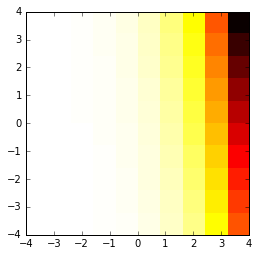

In [263]:
plt.show()